In [2]:
#Step 1 :-

# Import the necessary modules
import tensorflow.keras as keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import model_from_json
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import pickle
import sklearn as skl
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [3]:
#Step 2 :-

# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")


In [4]:
#Step 3 :-

# loading dataset

!curl --create-dirs -o /home/tcd/data/cifar10-dataset.pkl http://4c16.ml/~mindfreeze/cifar10-dataset.pkl


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  65.7M      0  0:00:02  0:00:02 --:--:-- 65.7M


loading the dataset...
loaded.
let's look at some of the pictures and their ground truth labels:


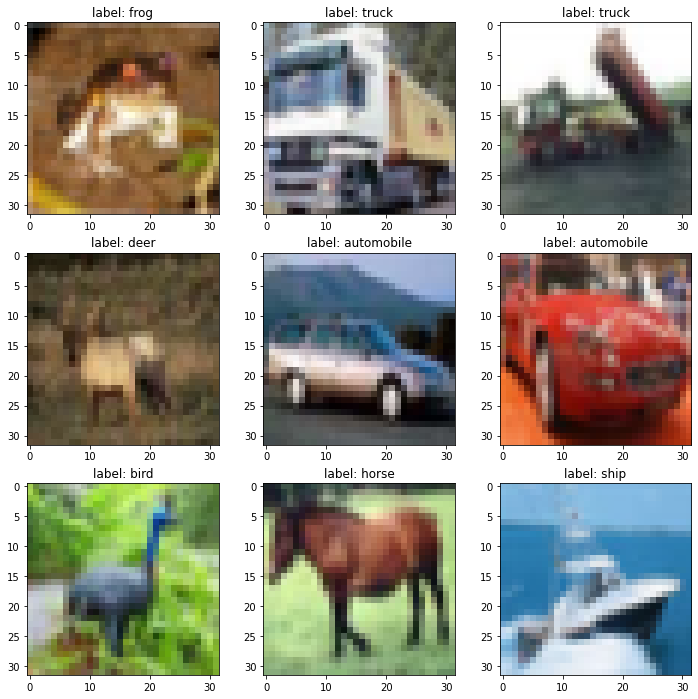

In [5]:
#Step 4 :-

print('loading the dataset...')

pkl_file = open('/home/tcd/data/cifar10-dataset.pkl', 'rb') 
dataset = pickle.load(pkl_file)

print('loaded.')

print('let\'s look at some of the pictures and their ground truth labels:')

plt.figure(figsize=(12,12))
plt.plot([3, 3])

X = dataset['X'].astype('float32')/255
Y = dataset['Y'].astype('float32')
Y = keras.utils.to_categorical(Y)

for i in range(0,9):
    # pictures are 32x32x3 (width=32, height=32, 3 colour channels)
    pic = X[i]

    # Y[i] returns an array of zeros and with Y[i][classid] = 1
    # for instance  Y[i] = [ 0 0 0 0 0 1 0 0 0 0] => classid=5 
    #          and  Y[i] = [ 1 0 0 0 0 0 0 0 0 0] => classid=0
    # we can get the classid by using the argmax function on the vector Y[i]
    classid = Y[i].argmax(-1)

    # getting back the name of the label for that classid
    classname = dataset['labels'][classid]
    plt.subplot(3,3,i+1)
    plt.imshow(pic)
    plt.title('label: {}'.format(classname))


In [6]:

#Step 5 :-

# let's split data between validation set and training set

X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)


In [8]:
#Step 6 :-

# the data structure is a tensor, ie. it is a multidimensional array
# each layer instance is callable on a tensor, and returns a tensor

# The model below contains 4 hidden layers with different nodes each. 
# The activation functions for these 4 layers is the ReLU or selu
# The network ends with a 10 nodes layer with softmax activation
# The first 4 hidden layers transform the original features into 
# a new feature vector of size 800, 500, 300, 60 respectively.
# The last layer essentially does the classification using multonomial regression
# based on these new features. 

inputs = keras.layers.Input(shape=(32, 32, 3))
x = Flatten()(inputs)
x = Dense(800, activation='selu')(x)
x = Dropout(0.09)(x)
x = Dense(500, activation='selu')(x)
x = Dropout(0.09)(x)
x = Dense(300, activation='selu')(x)
x = Dropout(0.09)(x)
x = Dense(60, activation='selu')(x)
x = Dropout(0.09)(x)
predictions = Dense(10, activation='softmax')(x)

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
#, decay=1e-6, momentum=0.9, nesterov=True

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

if (model.count_params() > 10000000):    
    raise("Your model is unecessarily complex, scale down!")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 800)               2458400   
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               400500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               150300

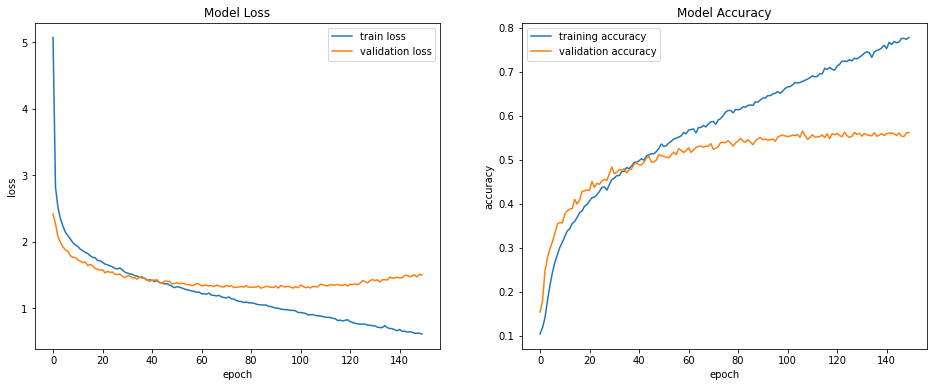

22/22 [==============================] - 14s 653ms/step - loss: 0.6134 - accuracy: 0.7775 - val_loss: 1.5024 - val_accuracy: 0.5612


In [10]:
#Step 7:-

# we create a callback function to plot our loss function and accuracy
pltCallBack = PlotLossAccuracy()

# and train
model.fit(X_train, Y_train,
          batch_size=2048, epochs=150, 
          validation_data=(X_validation, Y_validation), 
          callbacks=[pltCallBack])

# If you run this cell again, the optimisation starts where you left it.
# For instance, if you have set epochs=40 in the model.fit call,
# and that you run the cell 3 times, then you are effectively running for
# 120 iterations.
